## SSD Demo -- Noisy Detector

In [1]:
!ln -s /datasets/ee285f-public/nntools.py .

ln: failed to create symbolic link './nntools.py': File exists


In [2]:
%matplotlib inline
import os
import os.path as osp
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import math

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch.backends.cudnn as cudnn
import cv2
import ssd
from ssd import build_ssd
import random
from matplotlib import pyplot as plt
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform

from data import VOC_CLASSES as labels

In [3]:
if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
VOC_ROOT='//datasets/ee285f-public/PascalVOC2012/'

In [6]:
testset = VOCDetection(VOC_ROOT, [('2012', 'val')], None, VOCAnnotationTransform())

In [7]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

### LOAD SSD NET

In [8]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('ssd300_mAP_77.43_v2.pth')

Loading weights...
Finished!


### LOAD DUDnCNN NET

In [9]:
class NNRegressor(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()
        
    def criterion(self, y, d):
        return self.mse(y, d)

In [10]:
class DUDnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        
        self.conv.append(nn.Conv2d(3, C, 3, padding=1)) # Padding = (3-1)/2 ==> 1
        
        for k in range(D):
            if (k == D/2):
                l = 1
            elif(k > D/2):
                l += 2
            else:
                l = 0
            
            dil = int(1 + 2**(k-l) -1)
            self.conv.append(nn.Conv2d(C, C, 3, padding=dil, dilation=dil))
        
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
    
        for k in range(len(self.conv)-1):
            self.conv[k].weight.data = nn.init.kaiming_normal_(self.conv[k].weight.data, nonlinearity='relu')
        
        for k in range(D):    
            self.bn[k].weight.data = nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
        
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for k in range(D):
            torch.backends.cudnn.benchmark=True  # Q20 
            h = self.conv[k+1](h)
            torch.backends.cudnn.benchmark=False  # Q20
            h = F.relu(self.bn[k](h))
        
        y = self.conv[D+1](h) + x
        return y

In [11]:
net_DUDnCNN = torch.load('../Assignment_4_FINAL/denNet.pt')

In [12]:
impath = VOC_ROOT + "JPEGImages/" + random.choice(os.listdir(VOC_ROOT + "JPEGImages/"))
print(impath)

//datasets/ee285f-public/PascalVOC2012/JPEGImages/2010_000087.jpg


In [13]:
# impath = '//datasets/ee285f-public/PascalVOC2012/JPEGImages/----'

GOOD ONES:<br>
2011_000467.jpg<br>
2008_002243.jpg

In [83]:
def readImage(path, noisy=False, plot=False):
    orig = cv2.imread(impath, cv2.IMREAD_COLOR)
    rgb_image = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    orig_shape = orig.shape
    noisy_image = None
    
    if noisy:
        noisy_orig = orig[...,::-1]/255.0 #normalization 
        noise =  np.random.normal(loc=0.1, scale=1, size=noisy_orig.shape) #random sampling 

        # noise overlaid over image
        noisy = np.clip((noisy_orig + noise*0.2),0,1)
        noisy2 = np.clip((noisy_orig + noise*0.4),0,1)
        noisy3 = np.clip((noisy_orig + noise*0.8),0,1)
        
        orig = noisy*255.0
        noisy_image = orig
        
    x = cv2.resize(orig, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)

    if plot:
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.imshow(rgb_image)
        plt.subplot(122)
        plt.imshow((x*255).astype(np.uint8))

    return x, rgb_image, noisy_image

### Detect Original

In [84]:
x, rgb_image, noisy_image = readImage(impath, False)

In [85]:
img = x.unsqueeze(0)
if torch.cuda.is_available():
    img = img.cuda()
y = net(img)

<Figure size 720x720 with 0 Axes>

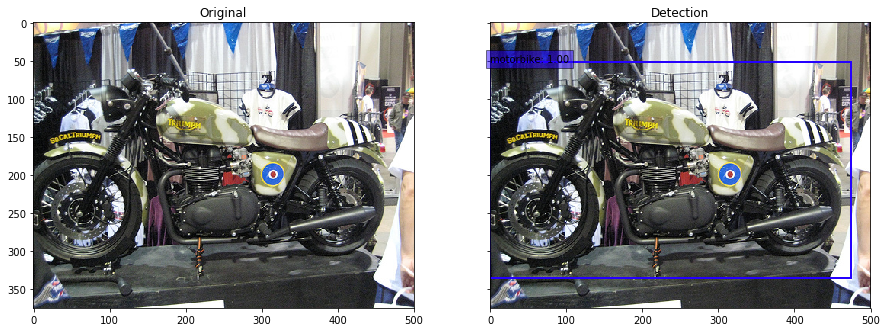

In [86]:
top_k=10
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
fig, axes = plt.subplots(1,2,sharex='all',sharey='all',figsize=(15,15))
    
axes[0].set_title('Original')    
axes[0].imshow(rgb_image)
axes[1].set_title('Detection')
axes[1].imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

### Detect Noisy

In [87]:
x, rgb_image, noisy_image = readImage(impath, noisy=True, plot=False)

In [88]:
img = x.unsqueeze(0)     # wrap tensor in Variable
if torch.cuda.is_available():
    img = img.cuda()
y = net(img)

<Figure size 720x720 with 0 Axes>

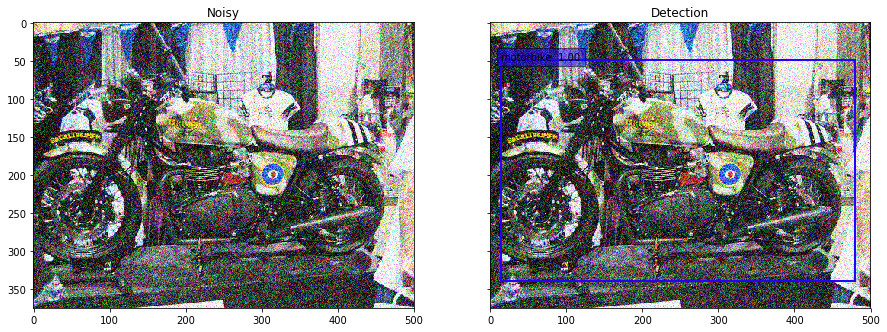

In [89]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

fig, axes = plt.subplots(1,2,sharex='all',sharey='all',figsize=(15,15))
    
axes[0].set_title('Noisy')    
axes[0].imshow(noisy_image/255)
axes[1].set_title('Detection')
axes[1].imshow(noisy_image/255)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

### Detect Denoised 

In [90]:
x, rgb_image, noisy_image = readImage(impath, noisy=True, plot=False)

In [91]:
def getDenoised(noisy_image, net_DUDnCNN):
    denoised = noisy_image
    im = Image.fromarray(np.uint8(denoised))
    image_size = (300,300)

    # declare a tranform to convert the image to a tensor and normalize it between [-1, 1]
    transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                                tv.transforms.ToTensor(), tv.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) 
    
    denoised = transform(im).unsqueeze(0)
    y = (net_DUDnCNN.forward(denoised)).detach()
    denoised = y[0].permute(1,2,0).numpy()
    denoised = 255.0*((denoised+1)/2)
    
    im2 = Image.fromarray(np.uint8(denoised))
    tran = tv.transforms.Compose([tv.transforms.Resize((rgb_image.shape[0],rgb_image.shape[1])), tv.transforms.ToTensor()])
    denoised = tran(im2)
    denoised = (tran(im2)*255.0).permute(1,2,0).numpy()

    x = cv2.resize(denoised, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)
    
    return x, denoised

In [92]:
x, denoised_image = getDenoised(noisy_image, net_DUDnCNN)

In [93]:
img = x.unsqueeze(0)
if torch.cuda.is_available():
    img = img.cuda()
y = net(img)

<Figure size 720x720 with 0 Axes>

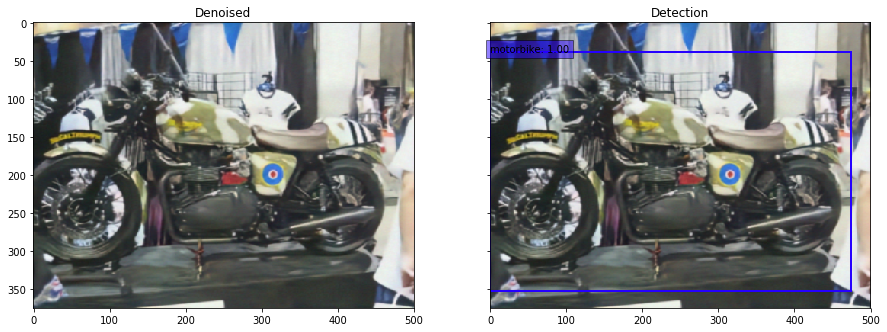

In [94]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

fig, axes = plt.subplots(1,2,sharex='all',sharey='all',figsize=(15,15))
 
axes[0].set_title('Denoised')    
axes[0].imshow(denoised_image/255)
axes[1].set_title('Detection')
axes[1].imshow(denoised_image/255)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1